In [15]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.externals.joblib as jbl
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
X, Y = jbl.load('traindata/X.jbl'), jbl.load('traindata/Y.jbl')

In [3]:
X = X.astype('f4')

In [4]:
X.shape, Y.shape

((10000, 24, 32), (10000,))

In [5]:
IMG_HEIGHT = 24
IMG_WIDTH = 32
IMG_CHANNEL = 1
n_classes = np.unique(Y).shape[0]

In [6]:
X = X.reshape(-1, IMG_HEIGHT * IMG_WIDTH * IMG_CHANNEL)
Y = (np.arange(n_classes) == Y[:,None]).astype(np.float32)
X.shape, Y.shape

((10000, 768), (10000, 4))

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [8]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [9]:
batch_size = 128
hidden_layer_size = 1024
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32, shape=(batch_size, IMG_HEIGHT * IMG_WIDTH * IMG_CHANNEL))
    y = tf.placeholder(tf.float32, shape=(batch_size, n_classes))
    W1 = tf.Variable(tf.truncated_normal(shape=(IMG_HEIGHT * IMG_WIDTH * IMG_CHANNEL, hidden_layer_size)), 
                     name='weights1')
    b1 = tf.Variable(tf.zeros(hidden_layer_size), name='bias1')
    W2 = tf.Variable(tf.truncated_normal(shape=(hidden_layer_size, n_classes)), name='weights2')
    b2 = tf.Variable(tf.zeros(n_classes), name='bias2')
    hidden1 = tf.nn.softmax(tf.matmul(x, W1) + b1)
    logits = tf.matmul(tf.nn.dropout(hidden1, keep_prob=0.25), W2) + b2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    ypred = tf.nn.softmax(logits)
    test_dataset = tf.constant(X_test)
    test_labels = tf.constant(Y_test)
    test_pred = tf.nn.softmax(tf.matmul(tf.nn.dropout(tf.nn.softmax(tf.matmul(test_dataset, W1) + b1), keep_prob=0.25), W2) + b2)
    saver = tf.train.Saver({'W1': W1, 'W2': W2, 'b1': b1, 'b2': b2})

In [10]:
num_iter = 3001

X_test_ = []
Y_test_ = []
Y_pred_ = []

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    for step in range(num_iter):
        offset = (step * batch_size) % (Y.shape[0] - batch_size)
        batch_data = X[offset: (offset+batch_size), :]
        batch_labels = Y[offset: (offset+batch_size), :]
        _, l, pred = sess.run([optimizer, loss, ypred],
                              feed_dict={x: batch_data, y: batch_labels})
        X_test_.extend(batch_data)
        Y_test_.extend(batch_labels)
        Y_pred_.extend(pred)
        if (step % 500 == 0):
            print("Train Accuracy: %.2f" % accuracy(pred, batch_labels))
    print("Test Accuracy: %.2f" % accuracy(test_pred.eval(), Y_test))

Train Accuracy: 36.72
Train Accuracy: 57.03
Train Accuracy: 43.75
Train Accuracy: 58.59
Train Accuracy: 54.69
Train Accuracy: 46.88
Train Accuracy: 53.12
Test Accuracy: 53.32


In [11]:
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    for step in range(num_iter):
        offset = (step * batch_size) % (Y.shape[0] - batch_size)
        batch_data = X[offset: (offset+batch_size), :]
        batch_labels = Y[offset: (offset+batch_size), :]
        sess.run([optimizer], feed_dict={x: batch_data, y: batch_labels})
    # Save the variables to disk.
    save_path = saver.save(sess, "models/model_tf_mlp.ckpt")
    print("Model saved in path: %s" % save_path)

Model saved in path: models/model_tf_mlp.ckpt


In [12]:
labeldict = jbl.load('traindata/Y.jbl').to_dict()
ixdict = {v: k for k, v in labeldict.items()}

In [13]:
Y_test_ = np.argmax(Y_test_, 1)
Y_pred_ = np.argmax(Y_pred_, 1)

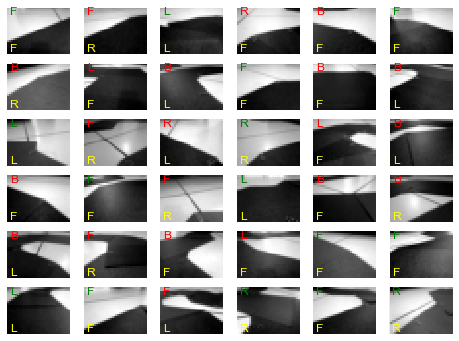

In [16]:
fig, axes = plt.subplots(6, 6, figsize=(8,6), 
                         subplot_kw=dict(xticks=[], yticks=[]))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    ax.text(.05, .05, 
            ixdict[Y_test_[i]], color='yellow', transform=ax.transAxes)
    ax.text(.05, .85, 
            ixdict[Y_pred_[i]], color='green' if Y_test_[i]==Y_pred_[i] else 'red',
            transform=ax.transAxes)
plt.axis('equal');